In [2]:
#from sklearn.datasets import fetch_mldata
#mnist = fetch_mldata('MNIST original')
#mnist
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

/Users/jianjin/anaconda/envs/mlbook/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/jianjin/anaconda/envs/mlbook/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
X, y = mnist['data'],mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

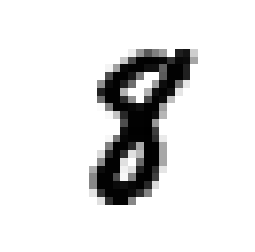

8.0


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

some_indice = np.random.randint(len(X))
some_digit = X[some_indice]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print(y[some_indice])

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen:

In [8]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. 

In [9]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(random_state=42,max_iter = 5)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([False])

### Evaluate Performance with Cross-Validation (Accuracy)

Evaluating a classifier is often significantly trickier than evaluating a regressor

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,
                scoring='accuracy',cv =4)

array([0.9675355 , 0.96346667, 0.96113333, 0.96133076])

over 95% accuracy! really? 

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

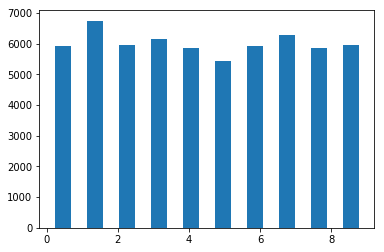

In [15]:
plt.hist(y_train,rwidth=0.5)

You can see, the proportion of each number is close to 10%. So even if we guess all the numbers is not 5, we can get a 90% accuracy rate.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

In [19]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53468,  1111],
       [ 1281,  4140]])

### Precision and Recall Rate

Recall Rate: the probability you detect something
Precision Rate: the probability you are correct when you detect something

In [22]:
from sklearn.metrics import recall_score, precision_score

In [23]:
recall_score(y_train_5,y_train_pred)

0.7636967349197565

In [24]:
precision_score(y_train_5,y_train_pred)

0.7884212530946486

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [28]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7758620689655172

**F1 score favors classifiers that have similar precision and recall. This is not always what you want**: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.

### Multiclass Classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

In [29]:
>>> sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
>>> sgd_clf.predict([some_digit])

array([8.])

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train,scoring='accuracy',cv=5)

array([0.86622241, 0.86568905, 0.88633333, 0.8312078 , 0.8822941 ])

In [32]:
>>> from sklearn.preprocessing import StandardScaler
>>> scaler = StandardScaler()
>>> X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
>>> cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90926815, 0.91229561, 0.90948642])